# EXTRACTION DES FEATURES,SELECTION ET PREMIERS ESSAIS


Le présent notebook présente les méthodes utilsées pour extraire les features, discute de leur importance etde l'utilité de l'utilisation d'une Principale Component Analysis pour la sélection des features. Enfin elle regroupe les 3 premiers essai de soumissions de features. 

Les dermatologues utilisent le code A (asymétrie), B (bords),C (couleurs),D (dimensions) pour détecter les mélanomes. J'ai extrait des features notamment grâce à l'article : *Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists* 
de Maciel Zorteaa,Thomas R. Schopfb, Kevin Thonb, Marc Geilhufea, Kristian Hindberga, Herbert Kircheschc,Kajsa Møllersenb, Jörn Schulza,Stein Olav Skrøvsethb,Fred Godtliebsen.


#### Asymétrie :
12,13, 24 (en utilisant scipy.stats.skew). 

#### Bords : 
-Distance euclidienne au centroid des contours, (features 0 et 1). Moyenne et variance de la couleur des contours, réalisé dans le canal bleu (features 18 et 19, dans le canal gris(20,21) et dans le canal de luminance des images masquée en lab (22,23). 

#### Couleur :
features 2,3, 7,8, 25,26,25,28 qui représentent la moyenne et la variance des valeurs de pixels de l'image masquée pour les cannaux (respectivement) bleu, gris, rouge et vert. 

Irrégularité de la distribution de couleur : en utilisant les features 'Geometric' décritent dans la publication. On seuille l'image aux 25è, 50è et 75è percentiles et on regarde le nombre de composantes connexes obtenues après seuillage. Plus il y en a, plus le grain de beauté a de chances d'être un mélanome.J'ai réalisé cela dans le cannal bleu (features 4,5,6) et l'image en niveaux de gris (features 9, 10,11)

On s'attend à ce que les features décrites par la publication soient celles qui ressortent le plus, et que la détection soit meilleur avec plus de features. Certaines features seront peut être peu importantes, il sera donc surement utile d'utiliser une méthode de sélection de features avant la détection. 

## Importations

In [4]:
# outils image
from skimage.io import imread
from skimage.transform import resize
from skimage import data
from skimage import filters
from skimage import exposure
from skimage import morphology as mph
from skimage.filters.rank import median
from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.filters.rank import minimum
from skimage.util import img_as_ubyte
from skimage import io, color
from skimage.filters import threshold_otsu
import cv2
from scipy import ndimage as ndi
import matplotlib.image as mpimg

#numpy, panda, scipy, pylab
import numpy as np
import pandas as pd
import os
from numpy import array, concatenate,imag, real, cumsum, arange, interp, maximum, transpose, linspace, pi, cos,sin
import scipy
import pylab
#outils d'affichage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.pyplot import plot, axis,subplot,imshow, grid

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")



"""
%pylab inline
%matplotlib inline
%cv2 inline
%load_ext autoreload
%autoreload 2
"""

# load code. 
from Loading_Data import * #permet d'obtenir les images en niveau de gris,bleu, etc..

## Outils de traitement d'image utiles pour le calcul des features : 

In [5]:
def get_pixels_mask(mask_) : 
    
    #INPUT : masque de segmentation
     #OUTPUT: liste des pixels du grain de beauté """
    
    l = []
    for i in range(mask_.shape[0]) : 
        for j in range(mask_.shape[1]) : 
            if mask_[i][j] == 1 or mask_[i][j] == 255  :
                l.append([i,j])
                
    return l


def get_contours(mask):
    #INPUT : masque de segmentation
    # OUTPUT: liste des pixels du contour du grain de beauté
    
    mask = mask.astype('uint8')
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
   
    #On récupère le contour le plus grand : 
    maxi = 0
    cnt = contours[0]
    for k in range(len(contours)) : 
        if len(contours[k]) > maxi : 
            maxi = len(contours[k])
            cnt = contours[k]
    return cnt 

def get_histogramm(im_onechannel,mask) : 
    #INPUT : image sur un seul cannal, masque de segmentation
     #OUTPUT: histogramme et l'intervalle de valeur de pixels pour lequel l'histogramme est non nul 
    
    histr = cv2.calcHist([im_onechannel],[0],None,[256],[1,256]) 
    a1 = 0
    
    while histr[a1] <1 : 
        a1 +=1 
    a2 = 0
    while histr[-a2] < 1 : 
            a2 +=1
    size = 256-a1-a2 #on a un paquet de pixel par niveau de gris
    hist = cv2.calcHist([im_onechannel],[0],None, [size],[a1,256-a2])

    return hist, a1, a2


def get_threesold_percentiles(hist,a1,a2,q) : 
    
  #    INPUT : histogramme, valeurs de l'intervalle ou celui ci est non nul, percentile q entre 0 et 1
   #  OUTPUT: valeur de pixel correspondant au qème percentile de l'histogramme
    
    
    total = np.sum(hist)#q entre 0 et 1
    a = total*q
    hist_sum = 0
    i = 0
    while hist_sum<a and hist_sum<total : 
        hist_sum += hist[i][0]
        i = i+1
    return i
        


def get_number_components(mask) :
    
  #    INPUT : masque de segmentation
  #   OUTPUT: Nombre de composantes connexes du masque de segmentation 
        
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask , 8, cv2.CV_32S)
    return num_labels


def get_centroid_moments(mask) : 
    
   #   INPUT : masque de segmentation
   #  OUTPUT: coordonnées du centroid du grain de beauté, et moments. un triplet de 0 est retourné si l'image 
   #  est toute noire 
    
    mask = mask.astype('uint8')

    cnt = get_contours(mask)
        
    M = cv2.moments(cnt)
        
    if M['m00'] != 0 : 
        cy = int(M['m10']/M['m00'])
        cx = int(M['m01']/M['m00'])  
        m = list(M.values())
        return cx, cy, m
    else : 
        return 0,0,0
    

# Extraction des features

## Asymétrie

Une mesure de l'asymétrie est proposée dans la publication. Il s'agit de réaliser des rotation des deux axes x et y puis d'obtenir le score de symétrie selon les axes x et y du masque. Pour cela on effectue la somme des valeurs 
$I_{i,j} - I_{i,-j}$  où $I_{i,j}$ vaut zéro si le pixel est dans le masque et 1 sinon. le pixel $(i,-j)$ représente le symétrique par rapport à l'axe y de $(i,j)$.On somme comme suit : 
<img src ='Asymetry_shape.jpg'>
Puis,on divise ensuite par le nombre de pixels du masque. On garde le meilleur score de symétrie après avoir testé toutes les rotations. 


Cependant, la méthode que j'ai réalisée était trop couteuse et j'ai donc choisi d'utiliser les scores de skew : 
d'abord en regardant la symétrie pour un axe puis pour l'autre dans *symetry_allegee* (features 12,13, l'une sur le masque l'autre sur l'image masquée en niveaux de gris). Ensuite en calculant simplement le score sur l'image réduite à une liste (*skewsym*, feature 24. 

On peut également calculer la symétrie de couleur et de forme grace à *asymetry_color_shape* qui calcule, grâce à plusieurs seuils, la moyenne  et la variance de la disposition des centroids et des moments  résultants (features 14,15,16,17)


In [6]:
def skewsym(im_masked_one_channel) :
 # INPUT : masque de segmentation OUTPUT: score de skew 
    
    res = scipy.stats.skew(im_masked_one_channel.reshape(-1))
    return res

def symetry_allegee(mask) : 
    #INPUT : masque de segmentation OUTPUT: score de skew pour les deux axes successivement 
    
    feat = scipy.stats.skew(mask,axis = None)
    return feat
    
    
def symetry_features(mask) :
    
    

#     NON UTILISE POUR CALCULER LES FEATURES CAR TROP LONG
#     INPUT : masque de segmentation
#     OUTPUT: valeurs de segmentation comme indiqué dans la publication. '''
    
    
    cx,cy,m = get_centroid_moments(mask)
    pixels = get_pixels_mask(mask)
    n = len(pixels)
    s1 = 0
    s2 = 0    
    
    for k in range(n) : 
        i = pixels[k][0]
        j = pixels[k][1]
    
        if i < cx and 2*cx - i < mask.shape[0]: 
            s1 += abs(mask[i][j]-mask[2*cx-i][j])
            
        if j<cy and 2*cy - j < mask.shape[1]: 
            s2 += abs(mask[i][j]-mask[i][2*cy-j])
            
    s1 = s1/n
    s2 = s2/n   
    
    for l in range(10,50,5) : 
        im = scipy.ndimage.interpolation.rotate(mask,l)
        cx,cy,m = get_centroid_moments(im)
        pixels = get_pixels_mask(im)
        n = len(pixels)

        s1_,s2_ = 0,0

        
        for k in range(n) : 
            
            i,j = pixels[k][0],pixels[k][1]
            
            if i < cx and 2*cx -i  < im.shape[0]: 
                s1_ += abs(im[i][j]-im[2*cx-i][j])
            
            if j<cy and 2*cy -j < im.shape[1]: 
                s2_ += abs(im[i][j]-im[i][2*cy-j]) 
                
        s1_ = s1_/n
        s2_ = s2_/n 
        if s1+s2 >s1_+s2_ : 
            s1,s2 = s1_ , s2_

    return s1,s2

def asymetry_color_shape(im,mask) : #im on one single channel
    x,y,m = get_centroid_moments(mask)
    v1 = []
    u1 = []
    hist,a1,a2 = get_histogramm(im,mask)
    for k in range(1,9) :
        seuil = get_threesold_percentiles(hist,a1,a2,k*0.1)
        ret, im_s = cv2.threshold(im , seuil, 255,cv2.THRESH_BINARY)

        xt,yt,mt = get_centroid_moments(im_s)
        
        if xt != 0 and yt!= 0 and mt != 0 : 
            d = np.sqrt((x-xt)**(2) + (y-yt)**(2))
            v1.append(d)
            
            d_m =np.sum([(m[i]-mt[i])**(2) for i in range(len(m))])
            u1.append(np.sqrt(d_m))
    
    if np.linalg.norm(u1) != 0 and np.linalg.norm(v1) !=0 : 
        u1 = u1/np.linalg.norm(u1)
        v1 = v1/np.linalg.norm(v1)
    
    nu_u = np.mean(u1)
    var_u = np.var(u1)
    
    nu_v = np.mean(v1)
    var_v = np.var(v1)
    
    return [nu_u,var_u], [nu_v,var_v]

features 12,13 : 2.106047914271773 2.5879066208813626
feature 24 2.106047914271773
features 14 à 17 : [0.3106284295777974, 0.028509978738031357][0.3044739127880395, 0.032295636431541326]
autre feature pas gardée : (2.6774233661357805, 6.089587011011089)


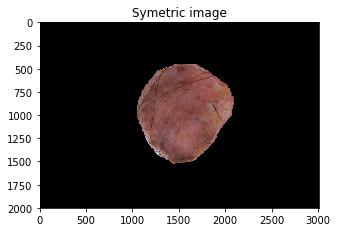

features 12,13 : 0.25576011890895123 0.5376460228695797
feature 24  : 0.25576011890895123
features 14 à 17 : [0.19387630373680406, 0.08741197884935448][0.16680257288284206, 0.0971769016796642]
autre feature pas gardée : (13.133345524474699, 17.749280329396775)


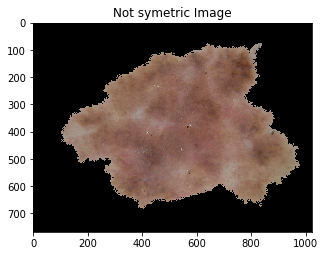

In [7]:
import cv2
M1 = 42 # a rather symetric image
im1 = masked_img(M1)
mask1 = load_segmentation(M1)
sym11 = skewsym(mask1)
sym12 = symetry_allegee(mask1)
sym13 = symetry_allegee(im1)
sym14 = symetry_features(mask1)
centroid1, moments1 = asymetry_color_shape(cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY),mask1)


M2 = 49 #not symetric image
im2 = masked_img(M2)
mask2 = load_segmentation(M2)
sym21 = skewsym(mask2)
sym22 = symetry_allegee(mask2)
sym23 = symetry_allegee(im2)
sym24 = symetry_features(mask2)
centroid2, moments2 = asymetry_color_shape(cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY),mask2)

plt.figure(figsize = (5,5))


plt.imshow(im1)
plt.title("Symetric image")
print('features 12,13 : ' + str(sym12)+ ' ' +str(sym13))
print( 'feature 24 ' + str(sym11))
print('features 14 à 17 : ' + str(centroid1)+ str(moments1))
print( 'autre feature pas gardée : '  + str(sym14))
plt.show()


plt.figure(figsize = (5,5))
plt.imshow(im2)
plt.title('Not symetric Image')
print('features 12,13 : ' + str(sym22)+ ' ' + str(sym23))
print('feature 24  : ' + str(sym21))
print('features 14 à 17 : ' + str(centroid2)+ str(moments2))
print( 'autre feature pas gardée : '  + str(sym24))

plt.show()


## Bords

Des bords assymétriques et de couleur variable peuvent être signe de mélanome. 
Les feature s 0 et 1 sont calculées avec la méthode *distance_to_centroid* qui calcule la moyenne et la variance de la distance euclidienne entre le centroid de l'image et les bords. 
Les features 19 à 23 représente la moyenne et la variance de couleur des bords dans les canaux, bleu, luminance et dans l'image en niveaux de gris. Elles sont calculées avec la fonction *mean_var_contour* ci-après. 


In [8]:
def distance_to_centroid(mask) :
    # INPUT : masque
    #OUTPUT : moyenne et varance de la distance des contours au centroid
    
    cx,cy,m = get_centroid_moments(mask)
    contours = get_contours(mask)
    
    v=[]
    for k in range(len(contours)):
        x = contours[k][0][0]
        y = contours[k][0][1]
        d = np.sqrt((cx-x)**(2) + (cy-y)**(2))
        v.append(d)
    v = v/np.linalg.norm(v)
    av = np.mean(v)
    var = np.var(v)
    
    return(av,var)


def mean_var_contour(im_onechannel_masked,mask) : 
    #INPUT : image sur un seul cannal, masque
    #OUTPUT : moyenne et variance de la couleur des contours
    
    cnt = get_contours(mask)
    v = []
    for k in range(len(cnt)) : 
        i = cnt[k][0][0]
        j = cnt[k][0][1]
        v.append(im_onechannel_masked[j][i])
    v = v/np.linalg.norm(v)
    
    m = np.mean(v)
    var = np.var(v)
    
    return m,var

features 0,1 : 0.010220846684404 2.659589200541499e-05
feature 19,20 (cannal bleu)0.0036738066902613376 0.00011756474335409826


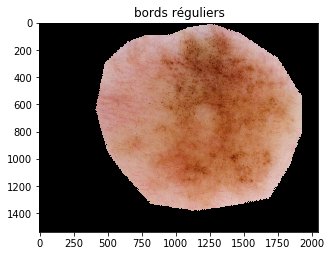

features 0,1 : 0.013060808094929223 3.2131691664171576e-05
feature 19,20 (cannal bleu)0.004576477330062598 0.0001817722550041634


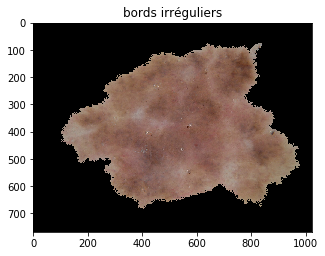

In [9]:
M1 = 97 # bords régulier
im1 = masked_img(M1)
mask1 = load_segmentation(M1)
blue1 = im1[:,:,2]
d1_mean, d1_var = distance_to_centroid(mask1)
c1_mean,c1_var = mean_var_contour(blue1,mask1)


plt.figure(figsize = (5,5))
plt.imshow(im1)
plt.title("bords réguliers")
print('features 0,1 : ' + str(d1_mean)+ ' ' +str(d1_var))
print( 'feature 19,20 (cannal bleu)' + str(c1_mean)+ ' ' +str(c1_var))
plt.show()


M2 = 49 #bords peu réguliers
im2 = masked_img(M2)
mask2 = load_segmentation(M2)
blue2 = im2[:,:,2]
d2_mean, d2_var = distance_to_centroid(mask2)
c2_mean,c2_var = mean_var_contour(blue2,mask2)


plt.figure(figsize = (5,5))
plt.imshow(im2)
plt.title("bords irréguliers")
print('features 0,1 : ' + str(d2_mean)+ ' ' +str(d2_var))
print( 'feature 19,20 (cannal bleu)' + str(c2_mean)+ ' ' +str(c2_var))
plt.show()
plt.show()


## Couleur

Une couleur très variable est signe de mélanome. 
Les features 2,3,7,8 et 25 à 28 sont calculées à partir des images dans chacun des trois canaux et en niveau de gris, elles représentent la moyenne et la variance des pixels dans le grain de beauté. 

les trois features geometriques(9,10,11) correspondent au nombre de composantes connexes après des seuillage au 25e, 50e et 75e percentiles de l'histogramme. 

In [10]:
def mean_var(im_onechannel_masked) : 
    #IMPUT : image masqué sur un seul canal, masque
    #OUTPUT :  moyenne et variance des valeurs de pixel
    mean = np.mean(im_onechannel_masked)
    var = np.var(im_onechannel_masked)
    return(mean,var)

In [11]:
def geometric(im_,mask,l = [25,50,70]) : 
    #INPUT : masque, (optionnel) liste des seuils
    #OUTPUT : nombre d'éléments dans l'image seuillée
    
    s=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    im=mph.opening(im_,s)
    hist,a1,a2 = get_histogramm(im,mask)
    
    res = []
    for k in l :
        seuil = get_threesold_percentiles(hist,a1,a2,k*0.01)
        ret, im_s = cv2.threshold(im , seuil, 255,cv2.THRESH_BINARY)
        
        res.append(get_number_components(im_s))
        
    return res

features 2,3 : 28.274890899658203 2657.8747968808925
feature 9,10,11 (cannal bleu)2 2 2


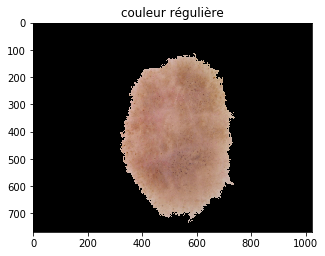

features 2,3 : 31.113993962605793 1954.2826755679346
feature 9,10,11 (cannal bleu)2 2 416


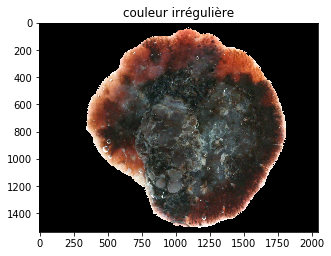

In [12]:
M1 = 16 # couleur régulière
im1 = masked_img(M1)
im11 = load_segmentation(M1)
blue1 = im1[:,:,2]
g11,g12,g13 = geometric(blue1,mask1)
c1_mean,c1_var = mean_var(blue1)


plt.figure(figsize = (5,5))
plt.imshow(im1)
plt.title("couleur régulière")
print('features 2,3 : ' + str(c1_mean)+ ' ' +str(c1_var))
print( 'feature 9,10,11 (cannal bleu)' + str(g11)+ ' ' +str(g12)+ ' ' +str(g13))
plt.show()


M2 = 60 #bords peu réguliers
im2 = masked_img(M2)
mask2 = load_segmentation(M2)
blue2 = im2[:,:,2]
g21,g22,g23 = geometric(blue2,mask2)
c2_mean,c2_var = mean_var(blue2)


plt.figure(figsize = (5,5))
plt.imshow(im2)
plt.title("couleur irrégulière")
print('features 2,3 : ' + str(c2_mean)+ ' ' +str(c2_var))
print( 'feature 9,10,11 (cannal bleu)' + str(g21)+ ' ' +str(g22)+ ' ' +str(g23))
plt.show()


# Feature selection.

La fonction suivante a été utilisée pour calculer les features. J'ai également souhaité regarder quelle était l'importance de mes features afin de voir si une méthode de sélection de features était nécessaire. 

In [13]:
def features(M) : 
    
    #INPUT : numéro de l'image
    #OUTPUT : features pour l'image M
    
    im = masked_img(M)
    im_lab = masked_lab(M)
    mask = load_segmentation(M)
    
    features = []
    
    dist = distance_to_centroid(mask)
    features.append(dist[0])
    features.append(dist[1])

    #blue
    print('bleu')
    b = im[:,:,2]
    
    mv = mean_var(b)
    features.append(mv[0])
    features.append(mv[1])
    
    mvc = mean_var_contour(b,mask)
    features.append(mvc[0])
    features.append(mvc[1])
    
    geom = geometric(b,mask)
    features.append(geom[0])
    features.append(geom[1])
    features.append(geom[2])
    
    
    #grey
    print('gris')
    gr = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    
    mv = mean_var(gr)
    features.append(mv[0])
    features.append(mv[1])
    
    mvc = mean_var_contour(gr,mask)
    features.append(mvc[0])
    features.append(mvc[1])
    
    geom = geometric(gr,mask)
    features.append(geom[0])
    features.append(geom[1])
    features.append(geom[2])
    
    features.append(symetry_allegee(mask))
    features.append(symetry_allegee(im))
    
    
    sym_c_s = asymetry_color_shape(gr,mask)
    features.append(sym_c_s[0][0])
    features.append(sym_c_s[0][1])
    features.append(sym_c_s[1][0])
    features.append(sym_c_s[1][1])
    
    #blue
    mvc = mean_var_contour(b,mask)
    features.append(mvc[0])
    features.append(mvc[1])
    
    
    #grey
    mvc = mean_var_contour(gr,mask)
    features.append(mvc[0])
    features.append(mvc[1])
    
    #luminance
    lum = im_lab [:,:,2]
    mvc = mean_var_contour(lum,mask)
    features.append(mvc[0])
    features.append(mvc[1])
    
    #skew_symetrie
    features.append(skewsym(gr))  
    
    #rouge
    r = im[:,:,0]
    
    
    #vert
    g = im[:,:,1]
    
    
    return features

bleu
gris
features : [0.01741919067167422, 5.797403703775014e-05, 9.300837198893229, 1036.110206004828, 0.006081039918455036, 0.0003244231942040487, 3, 7, 12, 12.109937032063803, 1716.869498016462, 0.006086950790034342, 0.0003243512707735926, 3, 3, 3, 2.986458695448714, 3.3741954342615896, 0.3535533905932738, 0.0, 0.35355339059327373, 0.0, 0.006081039918455036, 0.0003244231942040487, 0.006086950790034342, 0.0003243512707735926, 0.0060585273063654, 0.0003246964875719171, 3.207784507186091]


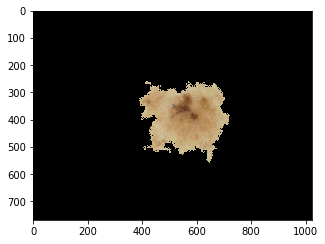

In [14]:
M = 0
im1 = masked_img(M)
plt.figure(figsize = (5,5))
plt.imshow(im1)
print("features : " + str(features(M)))


## Load all feature

J'ai stocké toutes mes features dans un fichier csv afin de ne pas perdre de temps.

In [15]:
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X = features[:,1:]
class_names = ["healthy","melanoma"]

labels = ['distance to centroid average', 'distance to centroid variance', 'blue : mean ', 'blue : variance ','blue : geometric seuil1', 'blue : geometric seuil2', 'blue : geometric seuil3', 'grey : mean ', 'grey : variance ',  'grey : geometric seuil1', 'grey : geometric seuil2', 'grey : geometric seuil3', 'Asymetry mask', 'Asymetry image', 'asymcolorshape1', 'asymcolorshape2', 'asymcolorshape3', 'asymcolorshape4', 'blue mean contour', 'blue var contour', 'grey mean contour', 'grey variance contour', 'luminance mean contour', 'luminance variance contour','skew wrapped','red mean', 'red variance', 'green mean','green variance'  ]

In [16]:
df2

,ImageId,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,24,25,26,27,28
0,IM_000000,0.017419,0.000058,9.300837,1036.110206,9.300837,1036.110206,3,7,12,...,0.000000,0.353553,0.000000,0.006081,0.000324,0.006087,0.000324,0.006059,0.000325,3.374195
1,IM_000001,0.015201,0.000025,39.762165,2563.596997,39.762165,2563.596997,2,2,18,...,0.072525,0.205346,0.082833,0.005471,0.000226,0.005473,0.000226,0.005429,0.000227,0.781174
2,IM_000002,0.014535,0.000002,9.451744,893.757616,9.451744,893.757616,2,2,5,...,0.000000,0.000000,0.000000,0.004652,0.000192,0.004688,0.000191,0.004643,0.000192,3.030813
3,IM_000003,0.029198,0.000089,3.745838,262.365631,3.745838,262.365631,29,35,63,...,0.091783,0.176095,0.093990,0.011656,0.000806,0.011672,0.000805,0.011409,0.000811,4.404111
4,IM_000004,0.011710,0.000022,8.549174,728.784001,8.549174,728.784001,2,15,38,...,0.012183,0.272086,0.050969,0.004031,0.000143,0.004035,0.000143,0.003971,0.000144,3.010378
5,IM_000005,0.018650,0.000044,6.363022,328.286493,6.363022,328.286493,2,2,2,...,0.000000,0.353553,0.000000,0.006426,0.000350,0.006456,0.000350,0.006313,0.000352,3.141263
6,IM_000006,0.016415,0.000030,43.773841,4562.958316,43.773841,4562.958316,2,25,45,...,0.000000,0.000000,0.000000,0.005636,0.000268,0.005646,0.000268,0.005131,0.000273,0.988302
7,IM_000007,0.004718,0.000003,24.355922,1545.179160,24.355922,1545.179160,52,65,132,...,0.000000,0.353553,0.000000,0.001583,0.000023,0.001583,0.000023,0.001575,0.000023,1.264766
8,IM_000008,0.020671,0.000013,2.514622,190.968481,2.514622,190.968481,106,106,106,...,0.000000,0.353553,0.000000,0.006039,0.000404,0.006087,0.000403,0.005913,0.000405,5.270294
9,IM_000009,0.018159,0.000062,20.594439,1351.764521,20.594439,1351.764521,182,330,419,...,0.050048,0.289880,0.040970,0.007472,0.000336,0.007537,0.000335,0.007069,0.000341,1.459706


## Importance of features : 

Feature ranking:
1. feature 26 representing distance to centroid average (0.051347)
2. feature 3 representing distance to centroid variance (0.050885)
3. feature 23 representing blue : mean  (0.046419)
4. feature 7 representing blue : variance  (0.044584)
5. feature 16 representing blue : geometric seuil1 (0.043682)
6. feature 17 representing blue : geometric seuil2 (0.041317)
7. feature 4 representing blue : geometric seuil3 (0.041239)
8. feature 28 representing grey : mean  (0.040847)
9. feature 25 representing grey : variance  (0.039499)
10. feature 2 representing grey : geometric seuil1 (0.038873)
11. feature 1 representing grey : geometric seuil2 (0.038297)
12. feature 8 representing grey : geometric seuil3 (0.035423)
13. feature 0 representing Asymetry mask (0.035412)
14. feature 20 representing Asymetry image (0.035280)
15. feature 21 representing asymcolorshape1 (0.035080)
16. feature 19 representing asymcolorshape2 (0.032998)
17. feature 15 representing asymcolorshape3 (0.0323

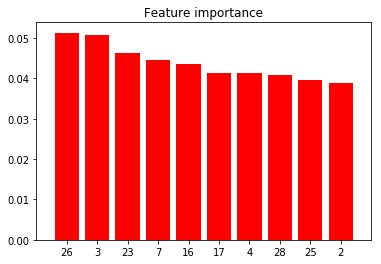

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# Let us rerun the feature importance without scaling the data. 
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.25, random_state=5)


RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5,iid = True)
grid_RF.fit(X_train, y_train)

best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(27):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

On voit clairement que les features n'ont pas toutes la même importance. Ainsi il semble nécessaire d'utiliser une méthode de sélection de features comme la PCA : elle permet d'être sûr de donner des features significatives aux algorithmes en projetant sur un espace de plus petites dimmension les features. Les essais 1 et 3 on donc été réalisé avec PCA ayant pour nombre de composantes 3. 

Sur le moment il m'a semblé logique de projeter sur 3 composantes car j'avais peu de features et c'est cela qui me donnait le meilleur score d'accuracy. Par la suite, j'ai testé plusieurs valeurs de nombre de composanres avant de soumettre mes prédictions. 

Les 3 exemples que j'ai pu réaliser m'ont permis de mettre en valeur l'importance de la symétrie pour la  prédiction, puisque le score s'est amélioré lorsque j'ai rajouté la symétrie en feature entre l'essai 1 et l'essai 2. J'avais rajouté quelques features à l'essai 2 mais sans succès,peut-être n'étais-ce pas suffisant. 

## Essai 1 : peu de features, pas de feature de symétrie

In [18]:
#loading data
#train set :
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X = features[:,3:12]

Normalized confusion matrix
[[0.85714286 0.14285714]
 [0.8961039  0.1038961 ]]
Accuracy0.5257142857142857


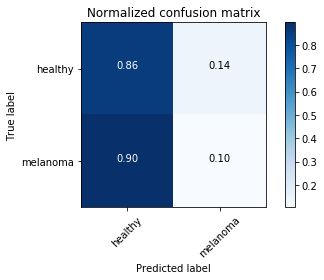

In [19]:
#split

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.25, random_state=5)

#scale data
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

from sklearn.decomposition import PCA

pca = PCA(n_components=3)  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)  

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=5, random_state=10)  
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test) 
y = y_pred

#plot confusion matrix

from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)  
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix') 
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

## Essai 3 : quelques features en plus 

In [20]:
#loading data
#train set :
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X = features[:,1:18]

Normalized confusion matrix
[[0.83673469 0.16326531]
 [0.83116883 0.16883117]]
Accuracy0.5428571428571428


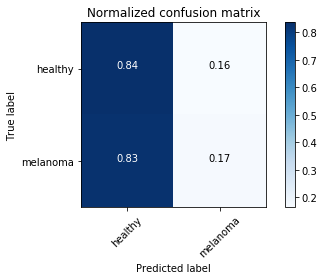

In [21]:
#split

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.25, random_state=5)

#scale data
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

from sklearn.decomposition import PCA

pca = PCA(n_components=3)  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)  

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=5, random_state=10)  
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test) 
y = y_pred

#plot confusion matrix

from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)  
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix') 
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

# Conclusion :  extraction et sélection de features

On constate effectivement que l'accuracy et la prédiction sont meilleures : on a plus de vrai positifs et de vrai négatifs que de faux positifs et de faux négatifs à l'essai 3.

Cependant on remarque que les labels sont mal réparttis. A l'avenir on utilisera des méthodes de resampling pour que cela ne gêne pas la prédiction.

Effectivement le score pour la deuxième prédiction est meilleur, mais il est encore très faible (<0.01). On améliorera ce score dans la suite en utilisant la cross validaiton pour déterminer les meilleurs paramètres des méthodes ainsi qu'en faisant du resampling. 

Ces méthodes, comparées aux mêmes en utilisant un score de PCA optimal, du resampling et de la cross-validation montrent bien l'utilité de ces méthodes pour la prédiction.

# APPENDICE : Code pour générer les CSV soumis au Kaggle :

## Essai 1

In [22]:
#loading data
#train set :
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y_train = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X_train = features[:,3:12]

#test set : 
df = pd.read_csv('data/test.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X_test = features[:,3:12]

In [23]:
#scale data
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

from sklearn.decomposition import PCA

pca = PCA(n_components=3)  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)  

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=5, random_state=10)  
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test) 
y = y_pred

In [24]:
df_submission = pd.read_csv('data/test.csv')
i = 0
for Id in df_submission['ImageId']:
    if Id != names[i] : 
        print('mismatch')
    value = y[i] # Draw a random number between 0 and 1 : binary classification : put here the result of
    i = i+1                # your classifier
    df_submission.loc[df_submission['ImageId'] == Id, 'Malignant'] = value
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/ESSAI1.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

     ImageId  Malignant
0  IM_000788          0
1  IM_000640          0
2  IM_000889          0


## Essai 3

In [25]:
#loading data
#train set :
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y_train = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X_train = features[:,1:18]

#test set : 
df = pd.read_csv('data/test.csv')
X_df = df['ImageId']
y_df = df['Malignant']
names = X_df.values
y = y_df.values

df2 = pd.read_csv('data/features.csv')
features_df = df2.loc[df2['ImageId'].isin(list(names))]
features = np.array(features_df.values)
X_test = features[:,1:18]

In [26]:
#scale data
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

from sklearn.decomposition import PCA

pca = PCA(n_components=3)  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)  

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=5, random_state=10)  
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test) 
y = y_pred

In [27]:
df_submission = pd.read_csv('data/test.csv')
i = 0
for Id in df_submission['ImageId']:
    if Id != names[i] : 
        print('mismatch')
    value = y[i] # Draw a random number between 0 and 1 : binary classification : put here the result of
    i = i+1                # your classifier
    df_submission.loc[df_submission['ImageId'] == Id, 'Malignant'] = value
df_submission['Malignant'] = df_submission['Malignant'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/ESSAI3.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

     ImageId  Malignant
0  IM_000788          0
1  IM_000640          0
2  IM_000889          0
